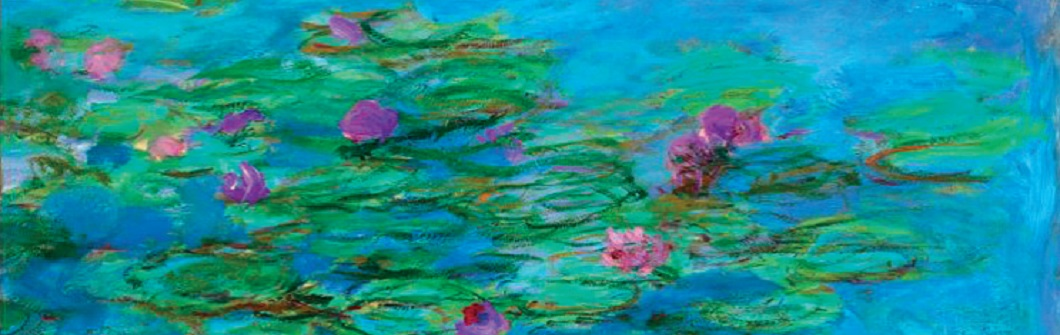

<center>
    
    
 ## I’m Something of a Painter Myself - A GAN CNN project
    
___


<center>

##### Pablo de la Asunción Cumbrera Conde


### Índice

 - Introducción
 - Rendimiento
 - Data Set y Librerias
 - Data Set Preprocesing & Visualization
 - Individual Image Analysis
 - Generator and Discriminator
 - Cycle GAN Model
 - Train the Model
 - Visualization and Comparing Results

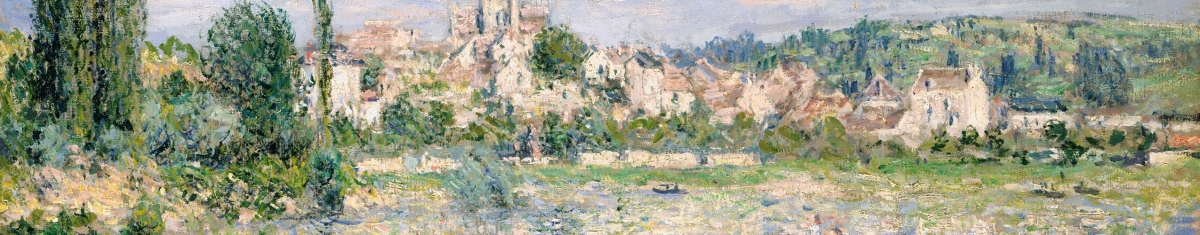

#### Introducción
____

“Every artist dips his brush in his own soul, and paints his own nature into his pictures.”
-Henry Ward Beecher

##### Dataset for including Cezanne, Ukiyo-e, and Van Gogh.
https://github.com/junyanz/CycleGAN

##### Kaggle Competition:
https://www.kaggle.com/c/gan-getting-started

##### What is a GAN?
A generative adversarial network (GAN) is a machine learning (ML) model in which two neural networks compete with each other to become more accurate in their predictions. GANs typically run unsupervised and use a cooperative zero-sum game framework to learn.

The two neural networks that make up a GAN are referred to as the generator and the discriminator. The generator is a convolutional neural network and the discriminator is a deconvolutional neural network. The goal of the generator is to artificially manufacture outputs that could easily be mistaken for real data. The goal of the discriminator is to identify which outputs it receives have been artificially created. 

#### How GANSs Work
The first step in establishing a GAN is to identify the desired end output and gather an initial training dataset based on those parameters. This data is then randomized and input into the generator until it acquires basic accuracy in producing outputs.

After this, the generated images are fed into the discriminator along with actual data points from the original concept. The discriminator filters through the information and returns a probability between 0 and 1 to represent each image's authenticity (1 correlates with real and 0 correlates with fake). These values are then manually checked for success and repeated until the desired outcome is reached.

- (https://searchenterpriseai.techtarget.com/definition/generative-adversarial-network-GAN)

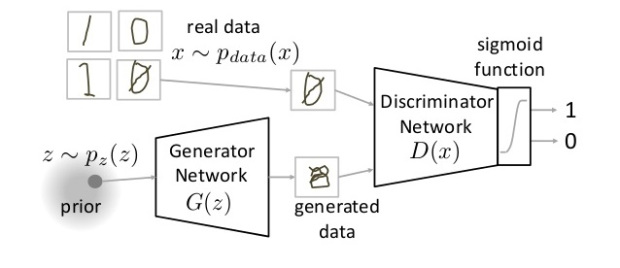

#### Librerias & Set Up
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import re
import cv2
import math
import random
import cv2
import math
import random
import keras
from keras import *
from keras.layers import *
import tensorflow_addons as tfa

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.4.1


In [3]:
def prepare_image(img, dim = 256):    
    img = tf.image.decode_jpeg(img, channels = 3)
    img = (tf.cast(img, tf.float32) / 255.0) - 1
    img = tf.reshape(img, [dim, dim, 3])
    return img

def read_tfrecord(example):
    tfrec_format = {
        'image' : tf.io.FixedLenFeature([], tf.string),
        'image_name' : tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }   
    
    example = tf.io.parse_single_example(example, tfrec_format)
    image = prepare_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

GCS_PATH = r"C:\Users\pablo\Downloads\gan-getting-started"
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

print(f"Monet file tfrecords: {len(MONET_FILENAMES)}")
print(f"Photo file tfrecords: {len(PHOTO_FILENAMES)}")
print(f"Monet images: {count_data_items(MONET_FILENAMES)}")
print(f"Photo images: {count_data_items(PHOTO_FILENAMES)}")

Monet file tfrecords: 5
Photo file tfrecords: 20
Monet images: 300
Photo images: 7038


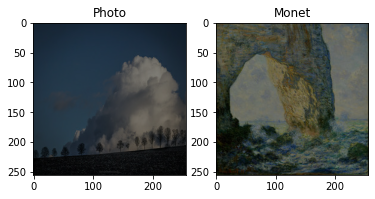

In [5]:
rand_photo = example_photo[0] * 0.5 + 0.5
rand_monet = example_monet[0] * 0.5 + 0.5

plt.subplot(121)
plt.title('Photo')
plt.imshow(rand_photo)

plt.subplot(122)
plt.title('Monet')
plt.imshow(rand_monet)

#### Data Set Preprocessing & Visualization
___

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
base_path = r'C:\Users\pablo\Downloads\gan-getting-started'
monet_path = os.path.join(base_path, 'monet_jpg')
photo_path = os.path.join(base_path, 'photo_jpg')

In [8]:
def batch_visualization(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)
    
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()

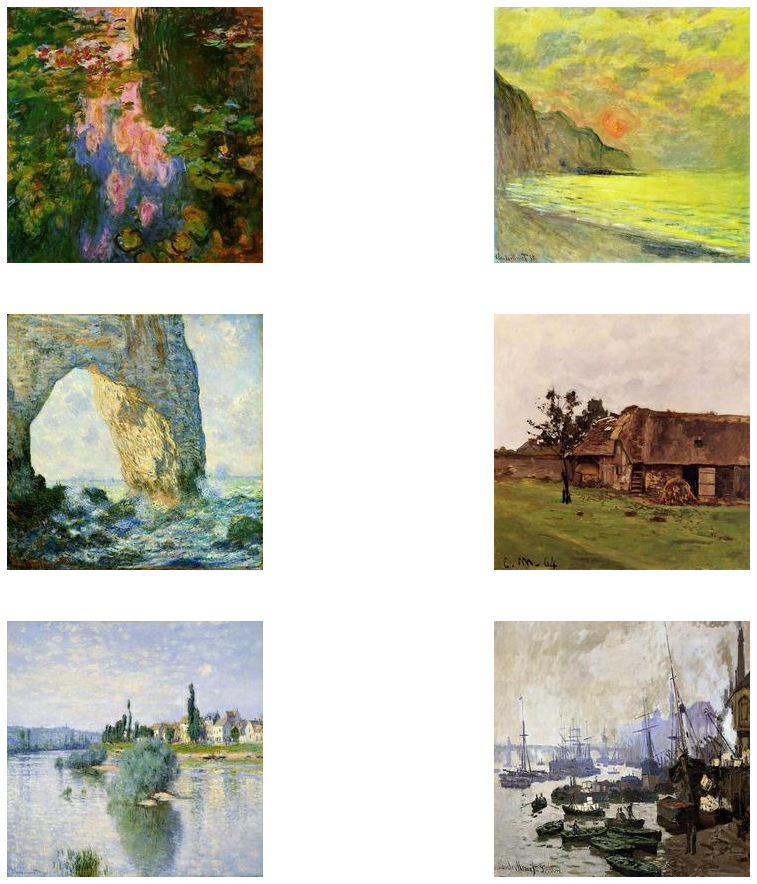

In [9]:
batch_visualization(monet_path,6)

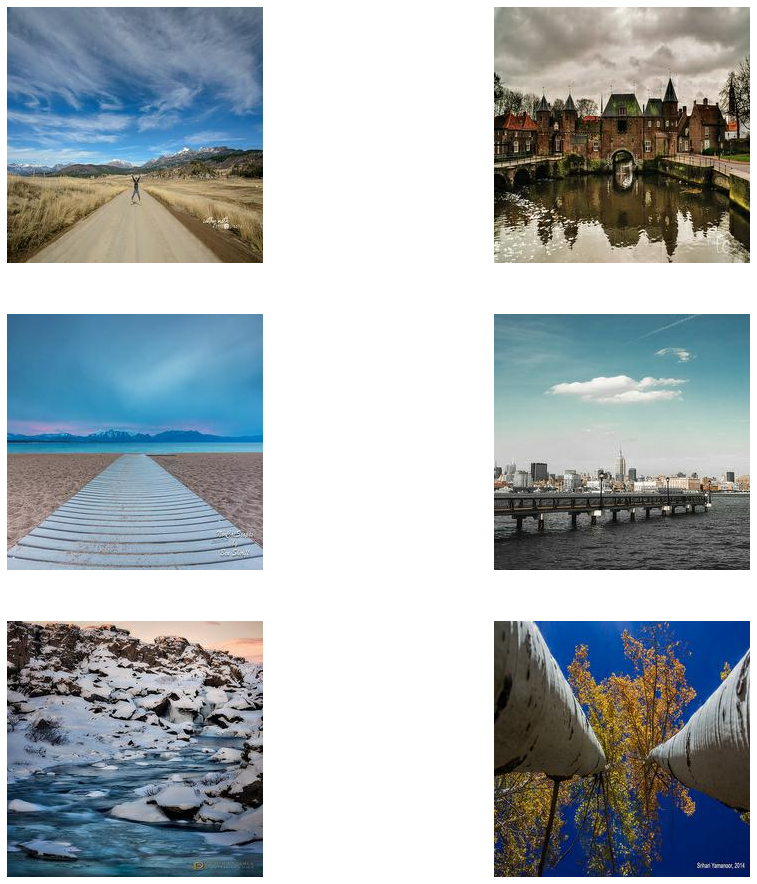

In [10]:
batch_visualization(photo_path,6)

#### Individual Image Analysis
___

In [11]:
def color_hist_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    layers = ['red', 'green', 'blue']
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis('off')
    
    for i in range(len(layers)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=25,
            alpha=0.5,
            color=layers[i],
            density=True
        )
        plt.title(layers[i])
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    plt.show()

Monet: 


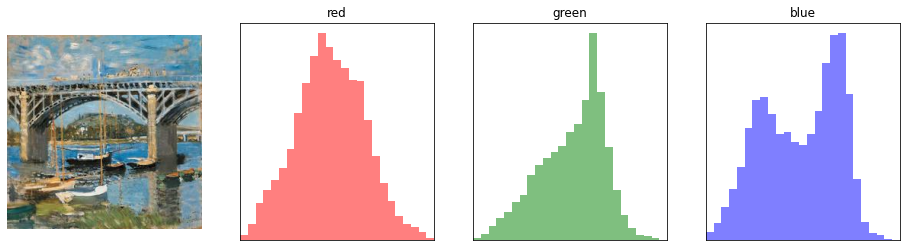


Photo: 


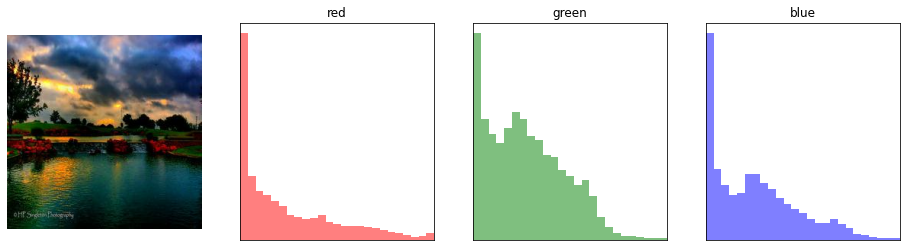

In [13]:
rand_monet = r"C:\Users\pablo\Downloads\gan-getting-started\monet_jpg\10c555c1b1.jpg"
rand_photo = r"C:\Users\pablo\Downloads\gan-getting-started\photo_jpg\3edae2ef79.jpg"

print("Monet: ")
color_hist_visualization(rand_monet)
print("\nPhoto: ")
color_hist_visualization(rand_photo)

In [14]:
def channels_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis('off')
    
    for i in range(3):
        plt.subplot(1, 4, i + 2)
        tmp_img = np.full_like(img, 0)
        tmp_img[:, :, i] = img[:, :, i]
        plt.imshow(tmp_img)
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    plt.show()

Monet: 


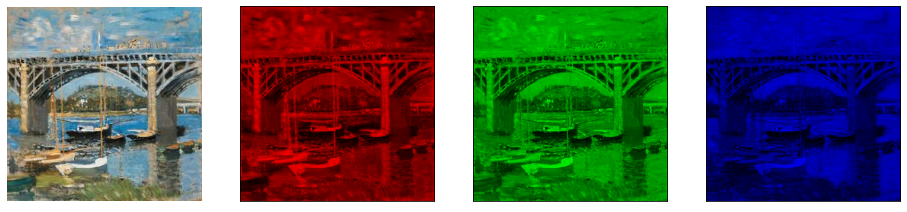


Photo: 


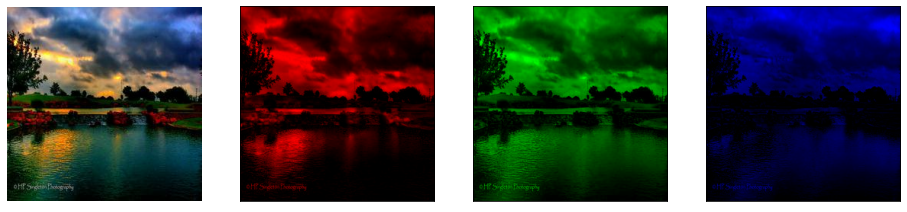

In [15]:
print("Monet: ")
channels_visualization(rand_monet)
print("\nPhoto: ")
channels_visualization(rand_photo)

In [16]:
def color_graph(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    
    chans = cv2.split(img)
    colors = ("b", "g", "r")
    plt.subplot(1, 2, 2)
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    features = []
    # loop over the image channels
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)
        # plot the histogram
        plt.plot(hist, color = color)
        plt.xlim([0, 256])
    
    plt.show()

Monet: 


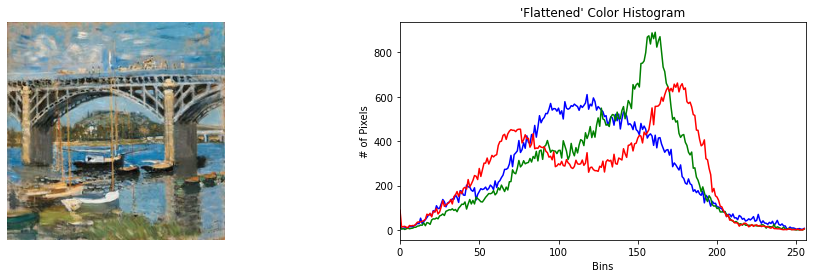


Photo: 


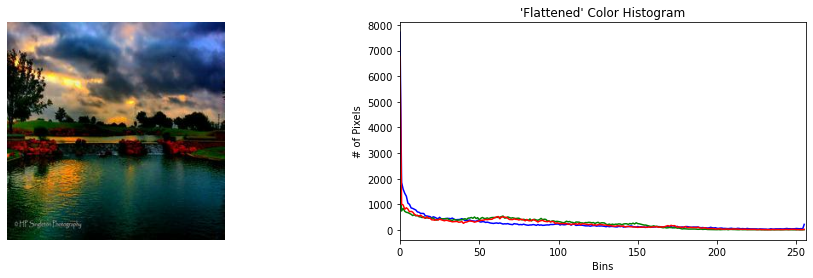

In [17]:
print("Monet: ")
color_graph(rand_monet)
print("\nPhoto: ")
color_graph(rand_photo)

#### Generator and Discriminator
___

In [18]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(Dropout(0.3))

    result.add(ReLU())

    return result

In [41]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1,
                  kernel_initializer=initializer,
                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = LeakyReLU()(norm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = Conv2D(1, 4, strides=1,
                  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [37]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [29]:
# Visualize Generator
generator_g = Generator()
tf.keras.utils.plot_model(generator_g, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [30]:
#Visualize Discriminator
discriminator_g = Discriminator()
tf.keras.utils.plot_model(discriminator_g, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [38]:
#GENERATOR
monet_generator.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_180 (Sequential)     (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
sequential_181 (Sequential)     (None, 64, 64, 128)  131328      sequential_180[0][0]             
__________________________________________________________________________________________________
sequential_182 (Sequential)     (None, 32, 32, 256)  524800      sequential_181[0][0]             
___________________________________________________________________________________________

In [39]:
#DISCRIMINATOR
monet_discriminator.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_210 (Sequential)  (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_211 (Sequential)  (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_212 (Sequential)  (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d_20 (ZeroPaddi (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 31, 31, 512)       2097152   
_________________________________________________________________
instance_normalization_200 ( (None, 31, 31, 512)       102

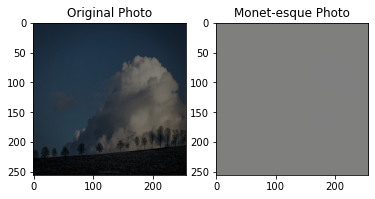

In [45]:
#MODEL HASNOT BEING YET TRAINED, SO IT CAN NOT GENERATE ANYTHING YET

to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

#### Cycle GAN Model
___

In [46]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10):
        
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn):  
        
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                   self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [47]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

In [48]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Train the model
___

In [49]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [50]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [54]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 1184s 4s/step - monet_gen_loss: 4.4597 - photo_gen_loss: 4.5757 - monet_disc_loss: 0.5742 - photo_disc_loss: 0.5683
Epoch 2/25
300/300 [==============================] - 1115s 4s/step - monet_gen_loss: 3.0949 - photo_gen_loss: 3.1107 - monet_disc_loss: 0.6667 - photo_disc_loss: 0.6690
Epoch 3/25
300/300 [==============================] - 1074s 4s/step - monet_gen_loss: 2.6890 - photo_gen_loss: 2.7288 - monet_disc_loss: 0.6834 - photo_disc_loss: 0.6762
Epoch 4/25
300/300 [==============================] - 1035s 3s/step - monet_gen_loss: 2.5651 - photo_gen_loss: 2.5962 - monet_disc_loss: 0.6737 - photo_disc_loss: 0.6679
Epoch 5/25
300/300 [==============================] - 1027s 3s/step - monet_gen_loss: 2.5713 - photo_gen_loss: 2.5967 - monet_disc_loss: 0.6659 - photo_disc_loss: 0.6609
Epoch 6/25
300/300 [==============================] - 1017s 3s/step - monet_gen_loss: 2.5861 - photo_gen_loss: 2.5941 - monet_disc_loss: 0.6570 - phot

In [79]:
# Guardar el Modelo
cycle_gan_model.save_weights(r"C:\Users\pablo\Data Science\modelos guardados", save_format='tf')

# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = keras.models.load_model('MonetesqueModelGAN.h5')

#### Visualization and Comparing Results
____

In [ ]:
_, ax = plt.subplots(10, 2, figsize=(30, 95))
for i, img in enumerate(photo_ds.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [132]:
img_path= r"C:\Users\pablo\OneDrive\Imágenes\skinner.jpg"
imagen= cv2.imread(img_path)

In [135]:
im = cv2.imread(r'C:\Users\pablo\OneDrive\Imágenes\sevilla catedral.jpg')
image = tf.image.resize(im,(416,416))/255
prediction = monet_generator(image, training=False)
plt.imshow(prediction, figsize=(10,12))
plt.savefig("Monetesque_pic")

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

#### Creating a submission file
___

In [ ]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(r"C:\Users\pablo\Downloads\submision\images" + str(i) + ".jpg")
    i += 1

In [75]:
import shutil
shutil.make_archive(r"C:\Users\pablo\Downloads\submision\images", 'zip', r"C:\Users\pablo\Downloads\submision\images")

'C:\\Users\\pablo\\Downloads\\submision\\images.zip'